In [23]:
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["figure.figsize"] = [16,9]

In [19]:
data = yf.download("ETH-USD",interval="5m",period="14d")
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-04-16 00:00:00+01:00,2531.811279,2533.920410,2531.811279,2533.652832,2533.652832,0
2021-04-16 00:05:00+01:00,2532.796875,2541.863037,2532.796875,2541.863037,2541.863037,10960896
2021-04-16 00:10:00+01:00,2544.267334,2544.267334,2537.512939,2537.669678,2537.669678,0
2021-04-16 00:15:00+01:00,2535.058838,2537.957275,2534.162598,2534.162598,2534.162598,0
2021-04-16 00:20:00+01:00,2532.070557,2532.070557,2517.732666,2523.502441,2523.502441,0


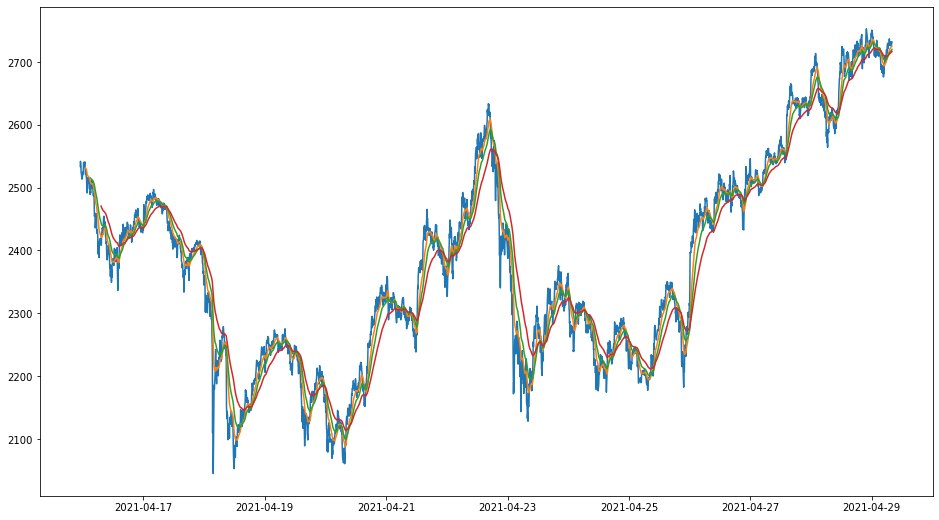

In [20]:
from ta.trend import EMAIndicator

data["EMA25"] = EMAIndicator(data["Close"],window=25).ema_indicator()
data["EMA50"] = EMAIndicator(data["Close"],window=50).ema_indicator()
data["EMA100"] = EMAIndicator(data["Close"],window=100).ema_indicator()
# can only start from highest ema

plt.plot(data["Close"],label="Price")
plt.plot(data["EMA25"],label="EMA25")
plt.plot(data["EMA50"],label="EMA50")
plt.plot(data["EMA100"],label="EMA100")

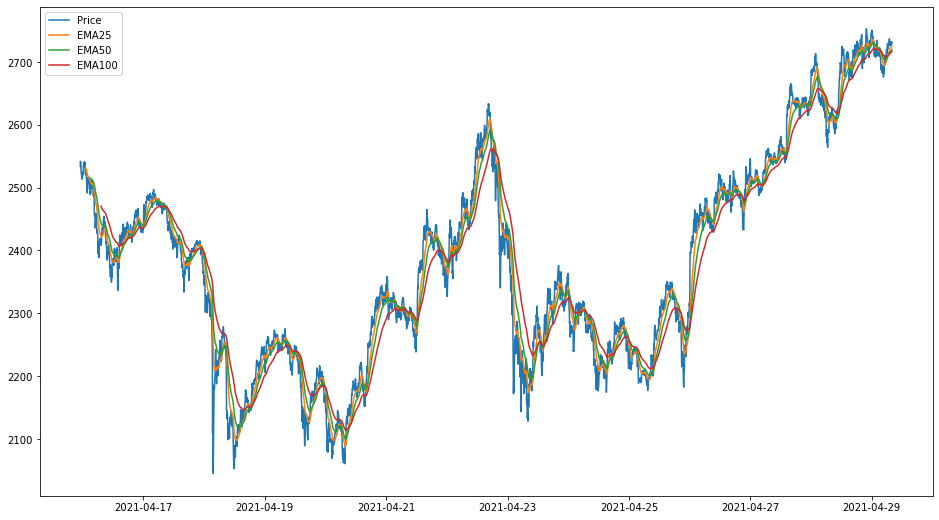

In [22]:
from ta.trend import EMAIndicator

data["EMA25"] = EMAIndicator(data["Close"],window=25).ema_indicator()
data["EMA50"] = EMAIndicator(data["Close"],window=50).ema_indicator()
data["EMA100"] = EMAIndicator(data["Close"],window=100).ema_indicator()

plt.plot(data["Close"],label="Price")
plt.plot(data["EMA25"],label="EMA25")
plt.plot(data["EMA50"],label="EMA50")
plt.plot(data["EMA100"],label="EMA100")
plt.legend()

In [100]:
startMoney = 40000
money = startMoney
nrStocks = 0
portfolio = []

waitForEntry = False

stopLoss = 0
takeProfit = 0
boughtAt = 0

def buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
    # and today crossed EMA25 take buy position
    # stopLoss = EMA50, takeProfit = 1.5 * EMA50
    boughtAt = crntPrice
    howmany = int(money / crntPrice)
    cost = howmany * crntPrice 
    money -= cost
    nrStocks += howmany
    stopLoss = data["EMA50"][i]
    takeProfit = data["EMA50"][i] * 1.5
    print(i,"Long Buying %d positions at %.2f$, SL: %.2f$, TP: %.2f$"%(howmany,crntPrice,stopLoss,takeProfit))
    return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt
    
def sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
    # sell
    value = crntPrice * nrStocks
    money += value
    win = value - (nrStocks * boughtAt)
    nrStocks = 0
    # just for safety
    boughtAt = 0
    stopLoss = 0
    takeProfit = 0
    return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win
                

for i,crntPrice in tqdm(enumerate(data["Close"])):
    crntPrice = data["Close"][i]
    if i > 0:
        if nrStocks == 0:
            # if no positions yet
            if not waitForEntry:
                # set signals

                # trend
                trend = 0
                if data["EMA25"][i] > data["EMA25"][i-1] and data["EMA50"][i] > data["EMA50"][i-1] and data["EMA100"][i] > data["EMA100"][i-1] \
                    and data["EMA25"][i] > data["EMA50"][i] > data["EMA100"][i]:
                    trend = 1
                elif data["EMA25"][i] < data["EMA25"][i-1] and data["EMA50"][i] < data["EMA50"][i-1] and data["EMA100"][i] < data["EMA100"][i-1] \
                    and data["EMA25"][i] < data["EMA50"][i] < data["EMA100"][i]:
                    trend = -1

                # seperation
                # seperation = 1 is trend indicator in either direction, -1 is negative trend
                seperation = 0
                if abs(data["EMA25"][i]-data["EMA100"][i]) > abs(data["EMA25"][i-1]-data["EMA100"][i-1]):
                    # if the difference between 25 and 100 ema is getting bigger
                    seperation = 1
                elif abs(data["EMA25"][i]-data["EMA100"][i]) < abs(data["EMA25"][i-1]-data["EMA100"][i-1]):
                    seperation = -1

                # price above 25 candle
                # 1 = upwards trend, -1 = downwards trend
                priceOutside = 0
                if crntPrice > data["EMA25"][i]:
                    priceOutside = 1
                elif crntPrice < data["EMA25"][i]:
                    priceOutside = -1

                # combining signal
                uptrend = 0
                if trend == 1 and seperation == 1 and priceOutside == 1:
                    uptrend = 1
                elif trend == -1 and seperation == 1 and priceOutside == -1:
                    uptrend = -1 # equals downtrend

                # logic: if uptrend, wait for cnrtPrice to be lower than 25EMA, but higher than 50 EMA, wait for it to cross up to 25 EMA again
                if uptrend == 1:
                    print(i,"got uptrend, wait for entry!")
                    waitForEntry = True
                    uptrend = 0

            if waitForEntry:
                if data["Close"][i-1] < data["EMA25"][i-1] and data["Close"][i-1] > data["EMA50"][i-1]:
                    # wait for it to reach EMA25 again, if yesterday was EMA25 > crntPrice > EMA50
                    if crntPrice >= data["EMA25"][i]:
                        crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt = buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                        # reset wait values
                        waitForEntry = False
                        
        ## If we have positions just listen to exit 
        elif nrStocks > 0: # if we have long positions
            if crntPrice >= takeProfit:
                crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                print(i,"Long Sell TP, Profit: %.2f$, crntHolding: %.2f$"%(win,money))
                
            elif crntPrice <= stopLoss:
                crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                print(i,"Long Sell SL, Loss: %.2f$, crntHolding: %.2f$"%(win,money))         
        
            # also stop if lines start to cross
            # signal line cross
            emacross = 0
            if data["EMA25"][i-1] > data["EMA100"][i-1] and data["EMA25"][i] <= data["EMA100"][i]:
                emacross = -1
                
            if emacross == -1: 
                crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                print(i,"Long Sell EMAcross, Loss: %.2f$, crntHolding: %.2f$"%(win,money))
                
        elif nrStocks < 0: # if we have short positions
            pass
        
    # keep track of portfolio value
    portValue = money + (nrStocks * crntPrice)
    portfolio.append(portValue)

3850it [00:00, 34857.54it/s]

214 got uptrend, wait for entry!
231 Long Buying 16 positions at 2430.20$, SL: 2423.26$, TP: 3634.89$
240 Long Sell SL, Loss: -273.94$, crntHolding: 39726.06$
246 got uptrend, wait for entry!
340 Long Buying 16 positions at 2481.21$, SL: 2472.05$, TP: 3708.08$
359 Long Sell SL, Loss: -150.94$, crntHolding: 39575.12$
559 got uptrend, wait for entry!
559 Long Buying 16 positions at 2412.07$, SL: 2402.85$, TP: 3604.27$
567 Long Sell SL, Loss: -182.09$, crntHolding: 39393.03$
813 got uptrend, wait for entry!
846 Long Buying 17 positions at 2208.20$, SL: 2192.65$, TP: 3288.97$
991 Long Sell EMAcross, Loss: 452.06$, crntHolding: 39845.09$
1126 got uptrend, wait for entry!
1130 Long Buying 18 positions at 2192.98$, SL: 2180.74$, TP: 3271.11$
1152 Long Sell SL, Loss: -263.75$, crntHolding: 39581.34$
1277 got uptrend, wait for entry!
1310 Long Buying 18 positions at 2180.53$, SL: 2163.14$, TP: 3244.71$
1343 Long Sell SL, Loss: -438.89$, crntHolding: 39142.45$
1356 got uptrend, wait for entry!
1

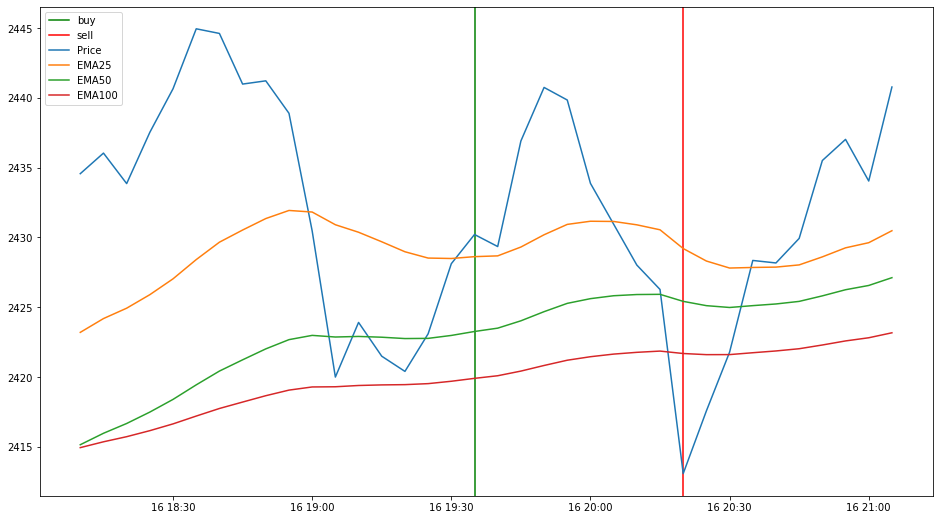

In [101]:
startWindow = 214
stopWindow = 250

buyline = 231
sellline = 240

plt.axvline(x=data.index[buyline],label="buy",color="g")
plt.axvline(x=data.index[sellline],label="sell",color="r")

plt.plot(data["Close"][startWindow:stopWindow],label="Price")
plt.plot(data["EMA25"][startWindow:stopWindow],label="EMA25")
plt.plot(data["EMA50"][startWindow:stopWindow],label="EMA50")
plt.plot(data["EMA100"][startWindow:stopWindow],label="EMA100")
plt.legend()